In [104]:
import pandas as pd
import numpy as np

# Evaluation fuctions

This notebook contains the evaluation functions used to evaluate the performance of the models. The evaluation functions are based on the evaluation metrics used in the paper "Using Data Mining to Predict Secondary School Student Performance" by P. Cortez and A. Silva.

In [105]:
def mean_squared_error(y_true, y_pred, squared=True):
    '''
    Calculate the mean squared error.

    y_true: np.array - the true labels
    y_pred: np.array - the predicted labels
    squared: bool - whether to square the error

    return: float - the mean squared error
    '''

    # Check if y_true and y_pred lengths match
    if len(y_true) != len(y_pred):
        raise ValueError("The number of samples in y_true and y_pred do not match.")

    # Calculate the error
    error = (y_true - y_pred) ** 2

    # Calculate the mean squared error
    if squared:
        return error.mean()
    else:
        return error.mean() ** 0.5

In [106]:
def accuracy_score(y_true, y_pred):
    '''
    Calculate the accuracy score.

    y_true: np.ndarray - the true target data
    y_pred: np.ndarray - the predicted target data

    return: float - the accuracy score
    '''

    # Check if y_true and y_pred lengths match
    if len(y_true) != len(y_pred):
        raise ValueError("The number of samples in y_true and y_pred do not match.")

    # Calculate the accuracy
    correct = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            correct += 1
    
    return correct / len(y_pred)

In [107]:
def evaluate_model(X, y, model) -> tuple:
    '''
    Evaluate the model on the data.

    X: pd.DataFrame - the features to evaluate the model on
    y: pd.DataFrame - the labels to evaluate the model on
    model: Model - the scikit-learn model to evaluate

    return: tuple - the model's score and predictions (RMSE for regression, accuracy for classification)
    '''

    # Check if X and model features match
    if len(X.iloc[0]) != len(model.feature_importances_):
        raise ValueError(f"The number of features in X and the model do not match ({len(X)} does not match model's {len(model.feature_importances_)} features).")

    # Evaluate the model
    y_pred = model.predict(X)
    
    # Calculate the score
    if model._estimator_type == 'regressor':
        score = mean_squared_error(np.array(y), np.array(y_pred), squared=False)
    else:
        score = accuracy_score(np.array(y), np.array(y_pred))

    return score

# Data cleaning
Similar to how the data was cleaned by Cortez and Silva in their paper, we create 1-of-C encoding for the categorical variables and normalize the numerical variables. We will also be adding columns for binary classification of the target variable and 5-Level classification of the target variable.

As there are no missing values in the dataset, we do not need to handle missing values.

In [108]:
# Read the data
maths = pd.read_csv("data/Maths.csv")
portugese = pd.read_csv("data/Portuguese.csv")

# Create dummy variables
maths = pd.get_dummies(maths, drop_first=True)
portugese = pd.get_dummies(portugese, drop_first=True)

# Normalize the features
from sklearn.preprocessing import StandardScaler
math_scaler = StandardScaler()
maths_scaled_features = math_scaler.fit_transform(maths.drop(columns=["G1", "G2", "G3"]))
maths_scaled_features = pd.DataFrame(maths_scaled_features, columns=maths.drop(columns=["G1", "G2", "G3"]).columns)
maths = pd.concat([maths_scaled_features, maths[["G1", "G2", "G3"]].reset_index(drop=True)], axis=1)

portugese_scaler = StandardScaler()
portugese_scaled_features = portugese_scaler.fit_transform(portugese.drop(columns=["G1", "G2", "G3"]))
portugese_scaled_features = pd.DataFrame(portugese_scaled_features, columns=portugese.drop(columns=["G1", "G2", "G3"]).columns)
portugese = pd.concat([portugese_scaled_features, portugese[["G1", "G2", "G3"]].reset_index(drop=True)], axis=1)

# Add binary classification target variable
maths["G3_binary"] = np.where(maths["G3"] >= 10, 1, 0)
portugese["G3_binary"] = np.where(portugese["G3"] >= 10, 1, 0)

# Add 5-Level classification target variable
maths["G3_5level"] = pd.cut(maths["G3"], bins=[0, 9, 11, 13, 15, 20], labels=[1, 2, 3, 4, 5], include_lowest=True)
portugese["G3_5level"] = pd.cut(portugese["G3"], bins=[0, 9, 11, 13, 15, 20], labels=[1, 2, 3, 4, 5], include_lowest=True)

# K-fold cross-validation
The paper uses a 10-fold cross-validation to evaluate the performance of the models. We will use the same approach to evaluate the performance of the models. To accomplish this, we will create a function that works independently of the model used. This function will take the features, target variable, the model, the number of folds ($k$), the number of times we repeat for each fold ($m$), and optionally the additional model parameters. It will return the average score and its standard deviation, as well as the inidivual scores for each fold and the SHAP values for each individual model. As we have $k \cdot m$ models, we will have $k \cdot m$ sets of SHAP values.

In [109]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from itertools import product
import shap


def k_fold_cross_validation(X, y, model_class, k=5, m=5, param_grid=None, **model_kwargs) -> tuple:
    '''
    Perform k-fold cross-validation on the model.

    X: pd.DataFrame - the features to evaluate the model on
    y: pd.DataFrame - the labels to evaluate the model on
    model_class: type - the scikit-learn model class to evaluate
    k: int - the number of folds
    m: int - the number of times to repeat the k-fold cross-validation
    param_grid: dict - the hyperparameters to search over using internal grid search (if None, no grid search is performed)
    model_kwargs: dict - additional keyword arguments to pass when initializing the model

    return: tuple - the model's average score and standard deviation, the scores for each model, and the SHAP values for each model
    '''

    # Create the folds
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=26)

    # Initialize variables to store the best model and scores
    scores = []
    shap_values = []

    # Evaluate the model on each fold
    for train_index, test_index in skf.split(X, y):
        for i in range(m):
            # Split the data for training and testing
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # If grid search is enabled, perform grid search
            best_params = {}
            if param_grid is not None:
                # Additional split for training and validation, to perform grid search
                X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=i)

                # Perform grid search
                if model_class()._estimator_type == 'classifier':
                    best_score = 0
                else:
                    best_score = float("inf")

                for params in product(*param_grid.values()):
                    model = model_class(random_state=i, **model_kwargs, **dict(zip(param_grid.keys(), params)))
                    model.fit(X_train, y_train)
                    score = evaluate_model(X_val, y_val, model)
                    if model._estimator_type == 'classifier' and score > best_score or model._estimator_type == 'regressor' and score < best_score:
                        best_params = dict(zip(param_grid.keys(), params))
                        best_score = score
            
            model = model_class(random_state=i, **model_kwargs, **best_params)
            model.fit(X_train, y_train)

            # Calculate SHAP values
            explainer = shap.Explainer(model)
            shap_values.append(explainer(X_test[:len(X)//k])) # We round down to make sure that all SHAP values are the same length. Otherwise, some SHAP value matrices might have one more row, due to not being able to perfectly divide the number of samples by k.

            # Evaluate the model
            score = evaluate_model(X_test, y_test, model)
            scores.append(score)

    # Check that we have k * m scores (sanity check)
    if len(scores) != k * m:
        raise ValueError(f"Expected {k * m} scores, got {len(scores)}.")
    
    # Calculate the average score and standard deviation
    scores = np.array(scores)
    avg_score = scores.mean()
    std_dev = scores.std()

    return avg_score, std_dev, scores, shap_values

# Helper functions for global visualization of SHAP values
We will need to calculate the average SHAP values for each feature across all models. We will create a function that takes the SHAP values and returns the average SHAP values for each feature. We will also create a function that takes the average SHAP values and plots the global importance of the features.

In [110]:
def get_average_shap_values(shap_values: list) -> np.ndarray:
    '''
    Calculate the average SHAP values.

    shap_values: list - the SHAP values for each model

    return: np.ndarray - the average SHAP values
    '''

    # Check if all SHAP values have the same shape
    if not all([shap_values[0].shape == shap_value.shape for shap_value in shap_values]):
        raise ValueError("All SHAP values must have the same shape.")

   # Create a preallocated array to store the SHAP values (faster than not preallocating)
    shap_values_array = np.zeros((len(shap_values),) + shap_values[0].shape, dtype=np.float32)

    # Assign each SHAP matrix to the preallocated array
    for i, shap_matrix in enumerate(shap_values):
        shap_values_array[i] = shap_matrix.values

    # Calculate the average
    avg = shap_values_array.mean(axis=(0, 1))

    # If we have multiple classes, we need to average the SHAP values for each class
    if len(avg.shape) > 1:
        if avg.shape[-1] == 2:
            # Special case of binary classification, averaging would result in all average values being 0, as the SHAP values are symmetrical
            avg = avg[..., 1]
        elif avg.shape[-1] > 2:
            # For multi-class classification, we need to average the SHAP values for each class
            avg = avg.mean(axis=-1)

    # Check if the average shape is correct before returning
    if len(avg.shape) != 1:
        raise ValueError(f"Expected the result to be a 1D array, got a {len(avg.shape)}D array.")

    return avg

In [111]:
import matplotlib.pyplot as plt

def plot_global_feature_importance(shap_values: np.ndarray, feature_names: list) -> None:
    '''
    Plot the global feature importance.

    shap_values: np.ndarray - the SHAP values as a vector
    feature_names: list - the feature names
    '''

    # Calculate absolute SHAP values
    shap_values = np.abs(shap_values)

    # Sort the SHAP values by magnitude
    sorted_indices = np.argsort(shap_values)[::-1]
    sorted_shap_values = shap_values[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Plot the SHAP values
    plt.figure(figsize=(25, 12))
    plt.barh(sorted_feature_names, sorted_shap_values)
    plt.xlabel("Absolute SHAP values", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
    plt.show()

# Demonstration
Before we continue with discussing how students can improve their grades, we will demonstrate the working of all previously mentioned functions. They combined will allow us to evaluate the performance of the models and visualize the global importance of the features.

We will use a simple Decision Tree model for the demonstration. We predict the final grade using all the features in the dataset, except for the target variable and the grade in period 1 and period 2 (G1 and G2). We take $k=10$ and $m=20$, resulting in $10 \cdot 20 = 200$ models. We will exclusively use the math dataset and not the Portuguese dataset.

d:\Bestanden\Documenten\GitHub\SHAP-analysis-for-student-advice\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Decision Tree Regressor RMSE: 5.513353206085446 ± 0.7466316768291896


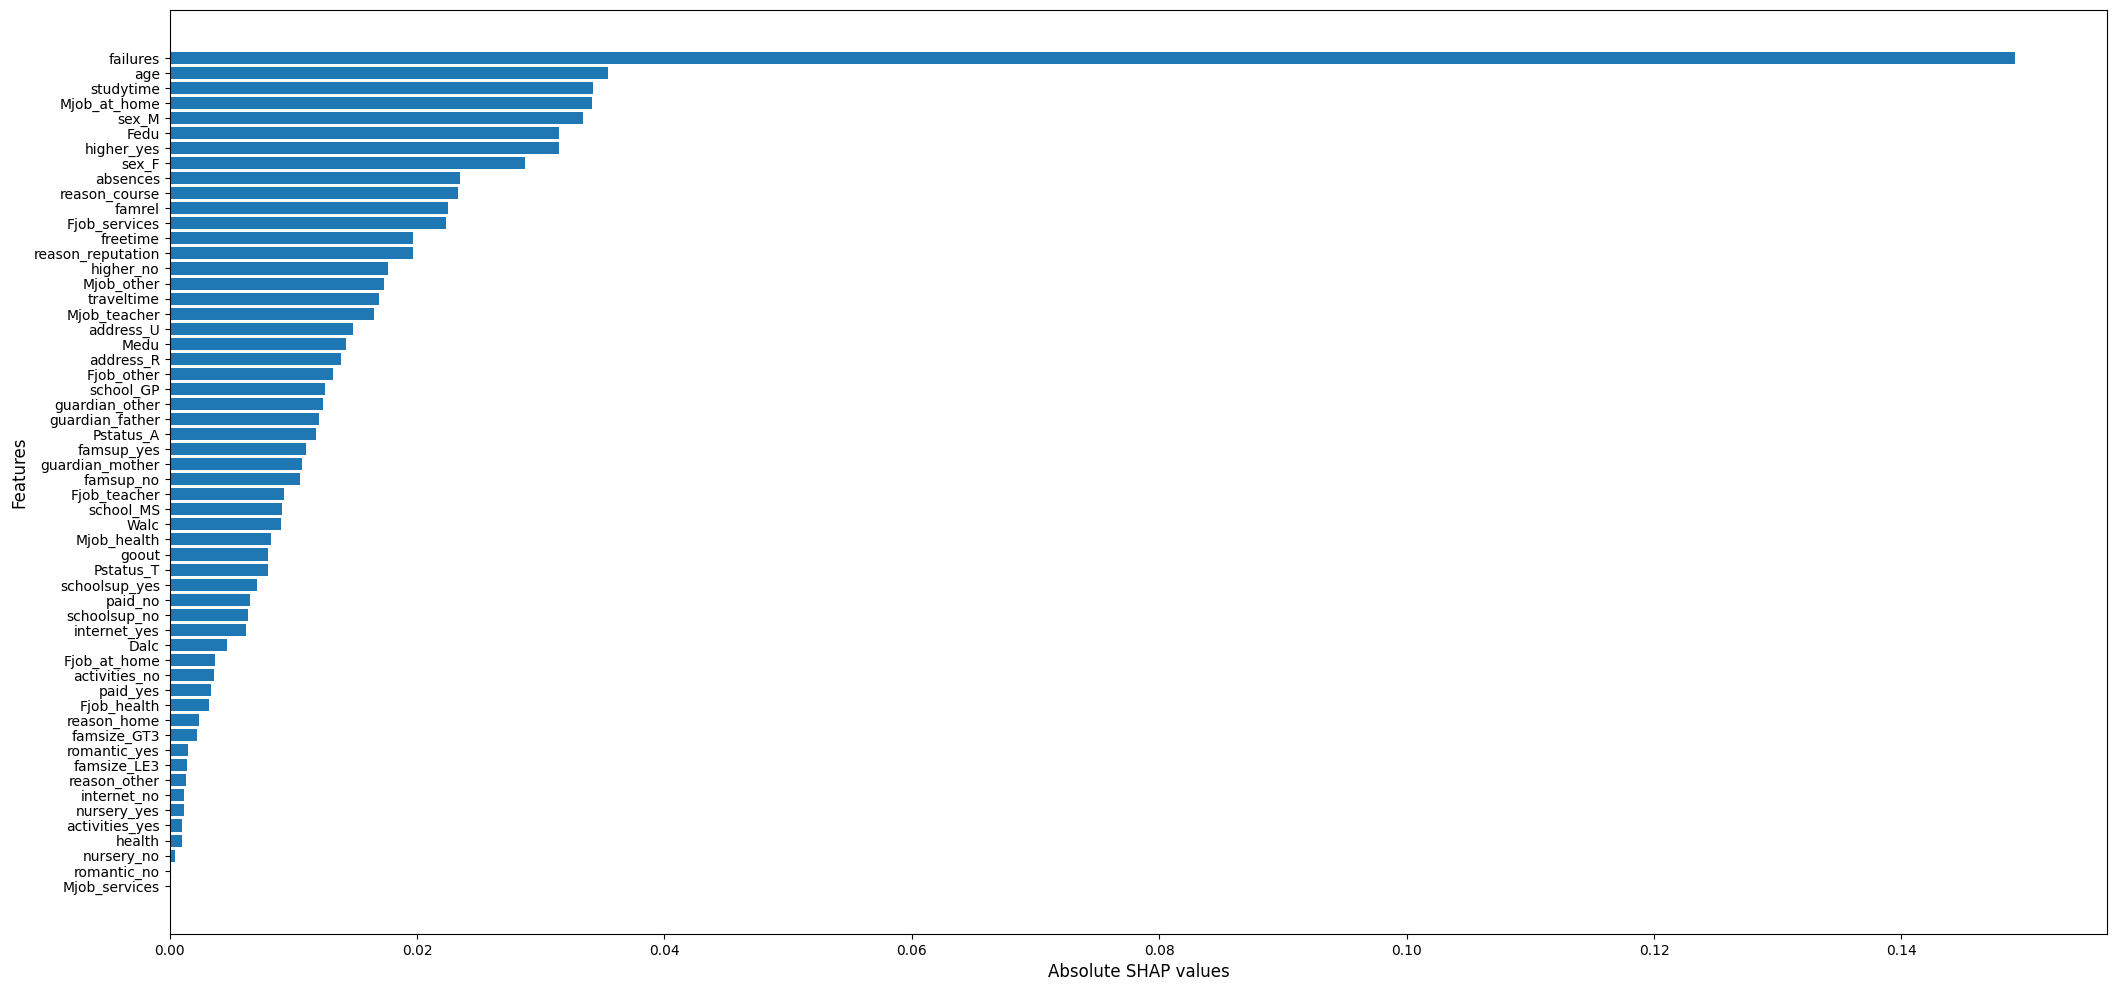

In [112]:
from sklearn.tree import DecisionTreeRegressor

avg, std, _, shap_values = k_fold_cross_validation(maths.drop(columns=["G1", "G2", "G3", "G3_binary", "G3_5level"]), maths["G3"], DecisionTreeRegressor, k=10, m=20)
print(f"Decision Tree Regressor RMSE: {avg} ± {std}")

# Get feature names
feature_names = maths.drop(columns=["G1", "G2", "G3", "G3_binary", "G3_5level"]).columns

plot_global_feature_importance(get_average_shap_values(shap_values), feature_names)


# Trying out the different models, according to the paper
The paper has identified several models as the best performing models for different scenarios. For each scenario, we will take the best performing model and use SHAP values to visualize the global importance of the features. 

It should be noted that most of the models are not significantly performing better than a naive estimator. However, increasing the accuracy of the models is not the main goal of this project. Our goal is to show how students can improve their grades.

The paper has the following scenarios and associated best performing models:

$$
\begin{array}{lll}
& \text{Math} & \text{Portuguese} \\
\text{Binary classification} & &  \\
\text{Setup A} & \text{Random Forests} & \text{Decision Trees} \\
\text{Setup B} & \text{Decision Trees} & \text{Random Forests} \\
\text{Setup C} & \text{SVMs} & \text{Random Forests} \\
\text{Five-level classification} & & \\
\text{Setup A} & \text{Decision Trees} & \text{Decision Trees} \\
\text{Setup B} & \text{Decision Trees} & \text{Decision Trees} \\
\text{Setup C} & \text{Random Forests} & \text{Random Forests} \\
\text{Regression} & &  \\
\text{Setup A} & \text{Random Forests} & \text{Random Forests} \\
\text{Setup B} & \text{Random Forests} & \text{Decision Trees} \\
\text{Setup C} & \text{Random Forests} & \text{Random Forests}
\end{array}
$$

Setup A uses all features. Setup B excludes using G2 and setup C excludes using G1 and G2. 

Evaluating with configuration Setup 1
Accuracy: 0.9099883449883451 ± 0.04012778875473112


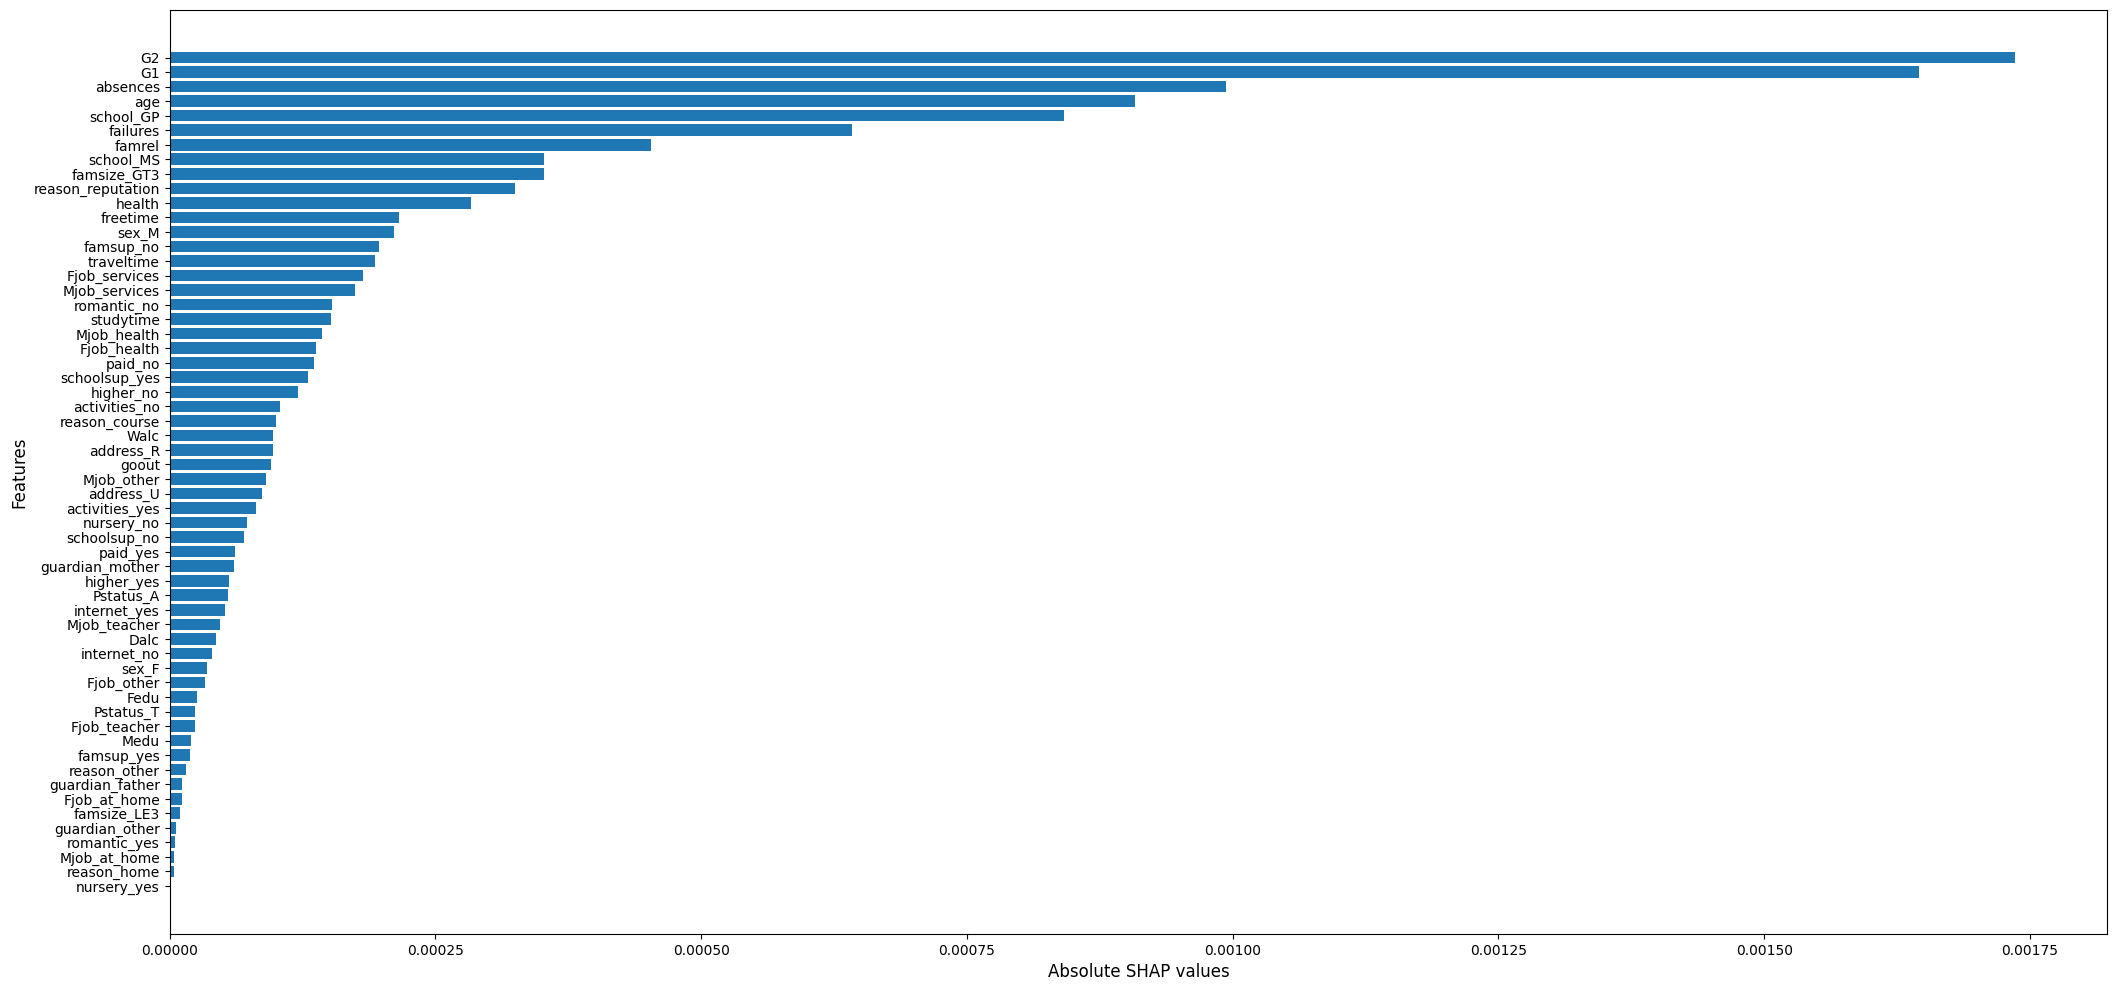

Evaluating with configuration Setup 2


KeyboardInterrupt: 

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

configurations = [
    {
        "name": "Setup 1",
        "model_class": DecisionTreeClassifier,
        "model_kwargs": {},
        "target": "G3_binary",
        "excluded_features": ["G3", "G3_binary", "G3_5level"],
        "dataset": portugese,
        "param_grid": {
            "max_depth": [None, 5, 10, 15, 20]
        }
    },
    {
        "name": "Setup 2",
        "model_class": RandomForestClassifier,
        "model_kwargs": {"n_estimators": 500},
        "target": "G3_binary",
        "excluded_features": ["G3", "G3_binary", "G3_5level"],
        "dataset": maths,
        "param_grid": None
    },
    {
        "name": "Setup 3",
        "model_class": DecisionTreeClassifier,
        "model_kwargs": {},
        "target": "G3_5level",
        "excluded_features": ["G3", "G3_binary", "G3_5level"],
        "dataset": maths,
        "param_grid": {
            "max_depth": [None, 5, 10, 15, 20]
        }
    }
]

for configuration in configurations:
    print(f"Evaluating with configuration {configuration["name"]}")
    avg, std, _, shap_values = k_fold_cross_validation(configuration["dataset"].drop(columns=configuration["excluded_features"]), configuration["dataset"][configuration["target"]], configuration["model_class"], k=10, m=20, param_grid=configuration["param_grid"], **configuration["model_kwargs"])
    print(f"Accuracy: {avg} ± {std}")

    # Write the results to a CSV-file (calculating the average SHAP values can take a while, so we save them to a file, to avoid recalculating them)
    with open("results.csv", "a") as f:
        f.write(configuration['name'])
        for shap_value in shap_values:
            f.write(",")
            f.write(str(shap_value))
        f.write("\n")

    # Get feature names
    feature_names = configuration["dataset"].drop(columns=configuration["excluded_features"]).columns

    # Plot the global feature importance
    plot_global_feature_importance(get_average_shap_values(shap_values), feature_names)